In [1]:
import pandas as pd

In [2]:
model_id = 18
combined_file_path = f"processed_trajectories/combined_m{model_id}_db.pkl"
df = pd.read_pickle(combined_file_path)


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 881 entries, 0 to 880
Data columns (total 22 columns):
 #   Column                                 Non-Null Count  Dtype 
---  ------                                 --------------  ----- 
 0   model_id                               881 non-null    int64 
 1   counter                                881 non-null    int64 
 2   timestamp                              881 non-null    object
 3   vendor                                 881 non-null    object
 4   model                                  881 non-null    object
 5   ut_id                                  881 non-null    object
 6   addi_fm_cnt                            881 non-null    int64 
 7   addi_fm_list                           881 non-null    object
 8   1.1 Disobey Task Specification         881 non-null    bool  
 9   1.2 Disobey Role Specification         881 non-null    bool  
 10  1.3 Step Repetition                    881 non-null    bool  
 11  1.4 Loss of Convers

In [4]:
failure_mode_keys = [
    "1.1 Disobey Task Specification",
    "1.2 Disobey Role Specification",
    "1.3 Step Repetition",
    "1.4 Loss of Conversation History",
    "1.5 Unaware of Termination Conditions",
    "2.1 Conversation Reset",
    "2.2 Fail to Ask for Clarification",
    "2.3 Task Derailment",
    "2.4 Information Withholding",
    "2.5 Ignored Other Agent's Input",
    "2.6 Action-Reasoning Mismatch",
    "3.1 Premature Termination",
    "3.2 No or Incorrect Verification",
    "3.3 Weak Verification",
]


In [5]:
selected_columns = ['addi_fm_cnt', 'addi_fm_list']
df_new_fm = df[df['addi_fm_cnt'] > 0][selected_columns]
df_new_fm.reset_index(drop=True, inplace=True)

In [6]:
print(df_new_fm)

     addi_fm_cnt                                       addi_fm_list
0              1  [{'title': 'Repeated Invalid Action Execution'...
1              1  [{'title': 'Specification Hallucination', 'des...
2              1  [{'title': 'Ineffective Remediation Loop', 'de...
3              2  [{'title': 'Inadequate Fallback Reasoning', 'd...
4              1  [{'title': 'Hallucinated Sensor Name', 'descri...
..           ...                                                ...
344            1  [{'title': 'Failure to Utilize Feedback Effect...
345            1  [{'title': 'Failure to Escalate After Repeated...
346            2  [{'title': 'Repetitive Error Handling without ...
347            2  [{'title': 'Ineffective Error Recovery', 'desc...
348            1  [{'title': 'Unproductive Error Loop', 'descrip...

[349 rows x 2 columns]


In [29]:
df_new_fm['addi_fm_cnt'].value_counts()

addi_fm_cnt
1    185
2    164
Name: count, dtype: int64

In [7]:
# Ensure full column width is printed
pd.set_option('display.max_colwidth', None)

# Print the first row
print(df_new_fm.iloc[0])

addi_fm_cnt                                                                                                                                                                                                                                                                                                                             1
addi_fm_list    [{'title': 'Repeated Invalid Action Execution', 'description': 'The agent persistently and unsuccessfully executed the same invalid 'Finish[answer]' action multiple times despite explicit feedback about its invalidity, indicating a lack of corrective behavior mechanism to recover from action selection errors.'}]
Name: 0, dtype: object


In [8]:
# Step 1: Explode the list so each dictionary becomes its own row
df_exploded = df_new_fm.explode('addi_fm_list', ignore_index=True)

# Step 2: Normalize the dictionary into separate columns
df_expanded = pd.concat([
    df_exploded.drop(columns=['addi_fm_list']),
    pd.json_normalize(df_exploded['addi_fm_list'])
], axis=1)

# Optional: Reset index if needed
df_expanded.reset_index(drop=True, inplace=True)


In [9]:
df_expanded.columns

Index(['addi_fm_cnt', 'title', 'description'], dtype='object')

In [10]:
df_expanded = df_expanded[['title', 'description']]

In [11]:
df_expanded.to_csv("summary/addtional_fm.csv", index=False)

In [12]:
df_expanded['title'].value_counts()


title
Ineffective Error Recovery                  14
Inadequate Error Recovery                    6
Inadequate Error Recovery Strategy           5
Insufficient Error Recovery                  5
Lack of Error Recovery Strategy              5
                                            ..
Answer Formatting Artifact                   1
Redundant Final Answer Generation            1
Failure to Handle Missing Data Robustly      1
Failure to Suggest User Remediation          1
Lack of Escalation or Assistance Request     1
Name: count, Length: 449, dtype: int64

In [13]:
df_new_fm_group = df_expanded.copy(deep=True)

In [14]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics.pairwise import euclidean_distances
from sentence_transformers import SentenceTransformer
import matplotlib.pyplot as plt



README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


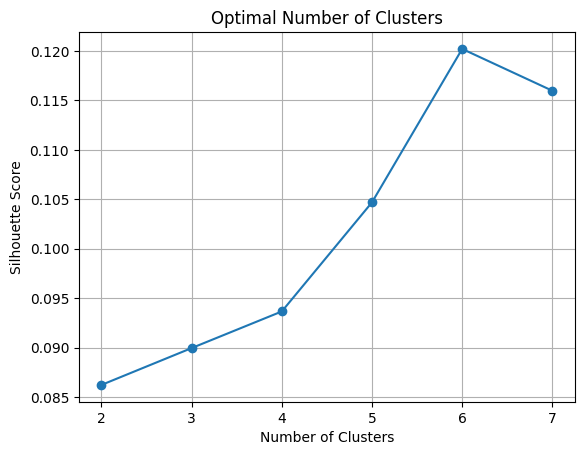


Optimal number of clusters: 6


In [15]:

# Step 2: Embed the titles
model = SentenceTransformer('all-MiniLM-L6-v2')
embeddings = model.encode(df_new_fm_group['title'].tolist())

# Step 3: Determine optimal number of clusters using silhouette scores
range_n_clusters = list(range(2, 8))
silhouette_scores = []

for n_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init='auto')
    labels = kmeans.fit_predict(embeddings)
    sil_score = silhouette_score(embeddings, labels)
    silhouette_scores.append(sil_score)

# Step 4: Plot silhouette scores
plt.plot(range_n_clusters, silhouette_scores, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Optimal Number of Clusters')
plt.grid(True)
plt.show()

# Step 5: Use the best cluster count
optimal_clusters = range_n_clusters[np.argmax(silhouette_scores)]
print(f"\nOptimal number of clusters: {optimal_clusters}")

# Step 6: Final clustering
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42, n_init='auto')
df_new_fm_group['cluster'] = kmeans.fit_predict(embeddings)

# Step 7: Find representative title for each cluster
representative_titles = []

for cluster_id in range(optimal_clusters):
    cluster_indices = df_new_fm_group[df_new_fm_group['cluster'] == cluster_id].index
    cluster_embeddings = embeddings[cluster_indices]
    cluster_center = kmeans.cluster_centers_[cluster_id]

    distances = euclidean_distances(cluster_embeddings, [cluster_center]).flatten()
    closest_index = cluster_indices[np.argmin(distances)]
    representative_title = df_new_fm_group.loc[closest_index, 'title']
    representative_titles.append((cluster_id, representative_title))



In [16]:
# Step 5: Use the best cluster count
optimal_clusters = range_n_clusters[np.argmax(silhouette_scores)]
print(f"\nOptimal number of clusters: {optimal_clusters}")

# Step 6: Final clustering
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42, n_init='auto')
df_new_fm_group['cluster'] = kmeans.fit_predict(embeddings)

# Step 7: Find representative title for each cluster
representative_titles = []

for cluster_id in range(optimal_clusters):
    cluster_indices = df_new_fm_group[df_new_fm_group['cluster'] == cluster_id].index
    cluster_embeddings = embeddings[cluster_indices]
    cluster_center = kmeans.cluster_centers_[cluster_id]

    distances = euclidean_distances(cluster_embeddings, [cluster_center]).flatten()
    closest_index = cluster_indices[np.argmin(distances)]
    representative_title = df_new_fm_group.loc[closest_index, 'title']
    representative_titles.append((cluster_id, representative_title))


Optimal number of clusters: 6


In [17]:
# Step 8: Print representative titles
print("\nRepresentative titles for each cluster:")
for cluster_id, title in representative_titles:
    print(f"Cluster {cluster_id}: {title}")


Representative titles for each cluster:
Cluster 0: Lack of Error Handling for Tool Failure
Cluster 1: Failure to Incorporate Feedback
Cluster 2: Invalid Action Formatting
Cluster 3: Overstatement of Task Completion
Cluster 4: Extraneous Output/Confusing Output Formatting
Cluster 5: Ineffective Error Recovery


In [19]:
# Step 8: Assign representative title as 'failure mode' for each row
cluster_to_title = {cluster_id: title for cluster_id, title in representative_titles}
df_new_fm_group['failure mode'] = df_new_fm_group['cluster'].map(cluster_to_title)


In [20]:
df_new_fm_group

,title,description,cluster,failure mode
0,Repeated Invalid Action Execution,"The agent persistently and unsuccessfully executed the same invalid 'Finish[answer]' action multiple times despite explicit feedback about its invalidity, indicating a lack of corrective behavior mechanism to recover from action selection errors.",2,Invalid Action Formatting
1,Specification Hallucination,"The agent listed failure modes as detectable by specified sensors without cross-verifying with the relevancy mapping, leading to incorrect inclusions in its final answer.",3,Overstatement of Task Completion
2,Ineffective Remediation Loop,"Despite receiving direct feedback and suggestions after every attempt, the agent repeats the same ineffective action, indicating a lack of adaptive remediation to past failure.",5,Ineffective Error Recovery
3,Inadequate Fallback Reasoning,"When the tools failed, the agent did not adequately default to self-ask and logical deduction, instead returning generic content and not addressing the asset-specific sensor/failure mode mapping as required.",3,Overstatement of Task Completion
4,Omitted Stepwise Transparency,"The agent failed to explicitly walk through the manual filtering process, skipping step-by-step reasoning, which made it difficult to verify or understand how the result was achieved.",3,Overstatement of Task Completion
...,...,...,...,...
508,Repetitive Error Handling without Escalation,"The agent persistently retries the same failing action (accessing a non-existent file) without altering its approach, attempting recovery, or providing helpful guidance to the user.",5,Ineffective Error Recovery
509,Lack of User-Facing Error Explanation,"Despite multiple failures, the agent does not provide a clear, user-facing summary of the problem or request for user intervention, impeding resolution and transparency.",5,Ineffective Error Recovery
510,Ineffective Error Recovery,"Despite identification of errors (e.g., missing or erroneous parameters), the agent persistently retries without substantial changes or escalation to alternative strategies such as seeking help or generating error reports.",5,Ineffective Error Recovery
511,Lack of Escalation or Assistance Request,"The agent fails to escalate the issue or request human intervention after repeated failures, as suggested in the agent's own review feedback, resulting in an unproductive loop.",3,Overstatement of Task Completion


In [32]:
df_new_fm_group['failure mode'].value_counts()


failure mode
Ineffective Error Recovery                       160
Overstatement of Task Completion                 122
Extraneous Output/Confusing Output Formatting    110
Lack of Error Handling for Tool Failure           53
Failure to Incorporate Feedback                   41
Invalid Action Formatting                         27
Name: count, dtype: int64

In [27]:
df_new_fm_group = df_new_fm_group[['cluster', 'failure mode','title', 'description']]

In [28]:
# Step 9: Save clustered data to CSV
df_new_fm_group.to_csv("summary/additional_fm_clustered.csv", index=False)
